# Una mirada al mundo de la especulación

### Imports

In [13]:
import requests
from requests_html import AsyncHTMLSession
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import secret
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
import nest_asyncio


In [4]:
nest_asyncio.apply()

### Config:

### 1) Twitter scrapping

In [34]:
import os
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys

chrome_options = Options()
chrome_options.add_argument("--headless")
driver = webdriver.Chrome(executable_path=os.path.abspath("chromedriver"), chrome_options=chrome_options)

c:\users\vasco\dataspellprojects\proyecto-icdd-g9\venv\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  
c:\users\vasco\dataspellprojects\proyecto-icdd-g9\venv\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: use options instead of chrome_options
  


In [39]:
driver.get("https://twitter.com/search?q=bitcoin&src=typed_query")

c:\users\vasco\dataspellprojects\proyecto-icdd-g9\venv\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: find_elements_by_* commands are deprecated. Please use find_elements() instead
  


[]

El siguiente codigo se va a tomar bastante tiempo, ya que literalmente tiene que navegar por twitter en un browser oculto

In [450]:
from datetime import datetime
import time


def get_articles():
    articles = []
    for _ in range(100):
        try:
            el = driver.find_elements(By.TAG_NAME, "article")

            html = driver.find_element(By.TAG_NAME, 'html')

            my = []
            for e in el:
                article = e.text.split("\n")
                if article[-1] == "Show this thread":
                    article[-1] = ""
                publisher = (article[0], article[1])
                date = e.find_element(By.TAG_NAME, "time").get_attribute("datetime")
                date = datetime.strptime(date, '%Y-%m-%dT%H:%M:%S.000Z')
                article = [x for x in article if len(x) >= 5]
                pub = ('\n'.join([at for at in article[4:] if
                                  at.strip('\t').strip(' ') != "" and not at.strip('\t').strip(' ').isdigit()])).replace(
                    '.\n', '. ').replace('\n', '. ')

                if len(list(filter(lambda x: x[0] == publisher and x[1] == date and x[2] == pub, articles))) == 0:
                    articles.append((publisher, date, pub))
                    print(len(articles))

            e.send_keys(Keys.PAGE_DOWN)
            time.sleep(0.3)
            e.send_keys(Keys.PAGE_DOWN)
            time.sleep(0.28)
            e.send_keys(Keys.PAGE_DOWN)

            time.sleep(0.5)
        except Exception as e:
            print("ERROR: ",e)
    return articles


articles = get_articles()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37


KeyboardInterrupt: 

In [454]:
#publisher_names = [article[0][0] for article in articles]
publisher_ids = [article[0][1][1:] for article in articles]
publisher_tweet_dates = [article[1].timestamp() for article in articles]
publisher_tweets = [article[2] for article in articles]

conv = zip(publisher_ids, publisher_tweet_dates, publisher_tweets)

df = pd.DataFrame(list(conv), columns=['p_id', 'date', 'tweet'])

Ahora cargemos lo que previamente teniamos en tweets.csv (No es necesario si es la primera vez que se corre el codigo)

In [304]:
if os.path.isfile("data/tweets.csv"):
    old_tweets = pd.read_csv("data/tweets.csv")
    df = df.append(old_tweets)
    df = df.drop_duplicates()

Convertir los tweets y guardarlos para el futuro

In [484]:
df.to_csv("data/tweets.csv")
df.head()

,p_id,date,tweet
0,DeAiDave,1.639348e+09,This is what #BTC maxis are missing. . New tec...
1,CriptoVitoko,1.639348e+09,"Die Bears, Die!! #Bitcoin. GIF"
2,Dan_Xuereb,1.639348e+09,Back to the 40s #bitcoin. GIF
3,CryptoSniper24,1.639348e+09,$IMX #IMX. Decision time . #Bitcoin $BTC . #Bi...
4,TuurDemeester,1.639348e+09,Some buzz going around about Paraguay potentia...


Ahora podemos empezar con el DataCleanup

Eliminar las filas en donde el tweet está vacío

In [485]:
import numpy as np
p_len = len(df)
df['tweet'].replace('', np.nan, inplace=True)
df.dropna(subset=['tweet'], inplace=True)
print(f"{p_len-len(df)} tweets eliminado(s)! ({len(df)} restantes)")

1 tweets eliminado(s)! (24882 restantes)


Eliminar las filas donde el tweet tiene menos de 188 characteres, para solo tener los tweets donde el texto es importante (no solo los archivos como imagenes o videos)

El 188 fue elegido ya que el promedio de characteres de una palabra en inglés (Estamos tomando los tweets en inglés ya que son los más influenciadores) es 4.7, por lo tanto si queremos 40 palablas minimo, usamos 188

In [497]:
p_len = len(df)
df = df[df['tweet'].str.len() > 188]
print(f"{p_len-len(df)} tweets eliminado(s)! ({len(df)} restantes)")

0 tweets eliminado(s)! (7431 restantes)


Eliminar usernames con espacios

In [498]:
p_len = len(df)
df = df[~(df['p_id'].str.contains(" "))]
df['p_id'].replace('', np.nan, inplace=True)
df.dropna(subset=['p_id'], inplace=True)
print(f"{p_len-len(df)} tweets eliminado(s)! ({len(df)} restantes)")

0 tweets eliminado(s)! (7431 restantes)


In [488]:
df["p_id"].unique()

array(['DeAiDave', 'CryptoSniper24', 'TuurDemeester', ..., 'ChefGruel',
       'tuihane_', 'yaneuraou'], dtype=object)

Con los tweets no utiles removidos del dataframe, ahora podemos ir a twitter a buscar la data de los usuarios restantes sin tener que hacer un request más largo al api, para después igual eliminar esos usuarios

In [489]:
def bearer_oauth(r):
    r.headers["Authorization"] = f"Bearer {secret.bearer_token}"
    r.headers["User-Agent"] = "v2UserLookupPython"
    return r


def get_users(users_list):
    usernames = f"usernames={','.join(users_list)}"
    user_fields = "user.fields=public_metrics,verified"
    url = "https://api.twitter.com/2/users/by?{}&{}".format(usernames, user_fields)
    response = requests.request("GET", url, auth=bearer_oauth, )
    if response.status_code != 200:
        raise Exception(
            "Request returned an error: {} {}".format(
                response.status_code, response.text
            )
        )
    return response.json()


# Only 300-requests/15-min to not be banned
users_list = list(set([user for user in df["p_id"]]))

print(f"{len(users_list)} unique users")

json_response = []
for i in range(0, len(users_list), 100):
    usrs = users_list[i:i + 100]
    print(f"Getting {len(usrs)*(i+1)}/{len(users_list)} users")
    n_u = get_users(usrs)["data"]
    print(len(n_u))
    json_response.extend(n_u)

4478 unique users
Getting 100/4478 users
100
Getting 10100/4478 users
100
Getting 20100/4478 users
100
Getting 30100/4478 users
100
Getting 40100/4478 users
100
Getting 50100/4478 users
100
Getting 60100/4478 users
100
Getting 70100/4478 users
100
Getting 80100/4478 users
100
Getting 90100/4478 users
100
Getting 100100/4478 users
100
Getting 110100/4478 users
100
Getting 120100/4478 users
100
Getting 130100/4478 users
100
Getting 140100/4478 users
99
Getting 150100/4478 users
100
Getting 160100/4478 users
100
Getting 170100/4478 users
100
Getting 180100/4478 users
100
Getting 190100/4478 users
100
Getting 200100/4478 users
100
Getting 210100/4478 users
100
Getting 220100/4478 users
100
Getting 230100/4478 users
99
Getting 240100/4478 users
100
Getting 250100/4478 users
100
Getting 260100/4478 users
100
Getting 270100/4478 users
100
Getting 280100/4478 users
100
Getting 290100/4478 users
100
Getting 300100/4478 users
100
Getting 310100/4478 users
100
Getting 320100/4478 users
100
Gettin

In [512]:
usernames = []
followers = []
following = []
listed_count = []
tweet_count = []
verified = []

u_ids = df["p_id"].unique()
for usr in json_response:
    if usr["username"] not in u_ids:
        continue
    usernames.append(usr["username"])
    followers.append(usr["public_metrics"]["followers_count"])
    following.append(usr["public_metrics"]["following_count"])
    listed_count.append(usr["public_metrics"]["listed_count"])
    tweet_count.append(usr["public_metrics"]["tweet_count"])
    verified.append(int(usr["verified"]))

df_users = pd.DataFrame(zip(usernames, followers, following, listed_count, tweet_count, verified),
                        columns=['username', 'followers', 'following', 'listed count', 'tweet count', 'verified'])
df_users

,username,followers,following,listed count,tweet count,verified
0,ThInvestForum,44478,85,0,12108,0
1,FerghaneA,28732,1166,167,17617,0
2,MrPlanN,14997,747,6,6274,0
3,peterhuntcrypto,151121,7463,57,9726,0
4,spiralbtc,104217,1,1471,828,1
...,...,...,...,...,...,...
1869,Crypto_Hawkk,392934,69,320,908,0
1870,dergigi,46790,962,950,48905,0
1871,ShibaAustralia,89798,1594,100,20145,0
1872,boardroom,65868,2371,293,6017,1


Ahora, hacemos el data cleanup de los usuarios y de los tweets que tienen a sus nombres


Eliminar los usuarios que tienen pocos seguidores:

In [533]:
p_len = len(df_users)
df_users = df_users[df_users['followers'] > 150000]
df_users.head()
print(f"{p_len-len(df_users)} usuarios eliminado(s)! ({len(df_users)} restantes)")

155 usuarios eliminado(s)! (608 restantes)


Eliminar usuarios con similar cantidad de followers que following o incluso menor followers que following (Muchos tienen seguidores porque siguen de regreso y no tienen mucho valor en este proyecto)

En este caso, la diferencia entre los followers y following, deben ser mayores a el 80% de la suma de estos

In [534]:
p_len = len(df_users)
df_users = df_users[df_users['followers']-df_users['following'] > (df_users['followers']+df_users['following'])*0.8]
print(f"{p_len-len(df_users)} usuarios eliminado(s)! ({len(df_users)} restantes)")
df_users

0 usuarios eliminado(s)! (608 restantes)


,username,followers,following,listed count,tweet count,verified
3,peterhuntcrypto,151121,7463,57,9726,0
8,rssurjewala,1727123,151,798,14742,1
11,goto_nikkei,285278,162,3242,3285,1
14,DrogCrypto,201501,362,527,18604,0
18,NewYorker,8994296,399,64198,131339,1
...,...,...,...,...,...,...
1859,shl,264192,24,4070,27785,1
1863,itsALLrisky,238236,507,414,14530,0
1866,garciabanchs,358529,2032,2042,137238,1
1869,Crypto_Hawkk,392934,69,320,908,0


Ahora, borramos los tweets de los usuarios que no están en la lista

In [535]:
p_len = len(df)
df = df[df['p_id'].isin(df_users["username"])]
print(f"{p_len-len(df)} tweets eliminado(s)! ({len(df)} restantes)")

539 tweets eliminado(s)! (4814 restantes)


Guardar los usuarios (Solo se corrió el codigo para descargar los usuarios)

In [ ]:
df_users.to_csv("data/users.csv")

Cargar los usuarios previamente creados

In [5]:
df_users = pd.read_csv("data/users.csv")

Ahora que tenemos la data 'limpia', podemos empezar a identificar el sentimiento de los tweets que quedan, para luego hacer regression para saber cuanto puede un usuario afectar los tweets, luego hacer k-cluster para saber los datos más importantes. (Solo correr si se tiene el api key de deepai.org y 2+ horas disponibles)

In [549]:
tweet_neg = []
tweet_neu = []
tweet_pos = []
tweet_vpos = []
tweet_vneg = []

tweet_beg = []
tweet_end = []

for t_id, tweet in enumerate(df["tweet"]):
    print(f"{t_id + 1}/{len(df['tweet'])}\r", end="")

    for error_n in range(50):
        try:
            r = requests.post(
                "https://api.deepai.org/api/sentiment-analysis",
                data={
                    'text': tweet,
                },
                headers={'api-key': secret.sentiment_key}
            )
            break
        except Exception as e:
            print(f"Error: {e}")
            time.sleep(10+error_n)
    for error_n in range(10):
        try:
            phrases = r.json()["output"]
            break
        except Exception as e:
            print(f"Error: {e}")
            time.sleep(1)
    if error_n == 9:
        print("Could not solve!")
        continue

    tweet_beg.append(phrases[0])
    tweet_end.append(phrases[-1])
    phs_vneg = 0
    phs_neg = 0
    phs_neu = 0
    phs_pos = 0
    phs_vpos = 0
    for ph in phrases:
        phs_vneg += ph == "Verynegative"
        phs_neg += ph == "Negative"
        phs_neu += ph == "Neutral"
        phs_pos += ph == "Positive"
        phs_vpos += ph == "Verypositive"
        if ph not in ["Verynegative", "Negative", "Neutral", "Positive", "Verypositive"]:
            print(f"New state found'{ph}'")
    tweet_vneg.append(phs_vneg)
    tweet_neg.append(phs_neg)
    tweet_neu.append(phs_neu)
    tweet_pos.append(phs_pos)
    tweet_vpos.append(phs_vpos)

print("Done!" + " "*20)

Done!                    


In [550]:
df['sentiment_begin'] = tweet_beg
df['sentiment_end'] = tweet_end

df['sentiment_very_positive'] = tweet_vpos
df['sentiment_positive'] = tweet_pos
df['sentiment_neutral'] = tweet_neu
df['sentiment_negative'] = tweet_neg
df['sentiment_very_negative'] = tweet_vneg

df

,p_id,date,tweet,sentiment_begin,sentiment_end,sentiment_very_positive,sentiment_positive,sentiment_neutral,sentiment_negative,sentiment_very_negative
4,TuurDemeester,1.639348e+09,Some buzz going around about Paraguay potentia...,Negative,Negative,0,0,2,4,0
16,rektcapital,1.639348e+09,Over 70% of #BTC investors believe that Bitcoi...,Negative,Neutral,0,0,9,1,0
24,DiMartinoBooth,1.639347e+09,“I don’t want to be overly technical but … the...,Negative,Negative,0,0,2,3,0
108,shibainuart,1.639341e+09,"$SHIB x Turkey ? Wow. coindesk.com. Tether, SH...",Negative,Neutral,0,1,2,3,0
173,OpIndia_com,1.639336e+09,"According to sources, the Ministry of Electron...",Negative,Neutral,0,0,2,2,1
...,...,...,...,...,...,...,...,...,...,...
24864,theRealKiyosaki,1.609522e+09,Happy New Year. 2021 great year for gold silve...,Positive,Positive,0,4,2,1,0
24870,woonomic,1.609507e+09,#Bitcoin is the first invention of an Internet...,Negative,Negative,0,0,4,2,0
24872,woonomic,1.609506e+09,If you're looking for an entry to HODL Bitcoin...,Negative,Negative,0,0,2,3,0
24878,jackmallers,1.609470e+09,What’s now known: You can’t save in USD. . Wha...,Negative,Neutral,0,3,4,2,0


Cargar los tweets con sentiment analysis (Solo correr si no se usó el sentiment analysis de los 2 bloques anteriores)

In [7]:
df = pd.read_csv("data/tweet_sentiment.csv")

Ahora podemos probar algunos de los tweets para saber si son clasificados correctamente

In [8]:
df[df["sentiment_positive"] > df["sentiment_negative"]].head()

,Unnamed: 0,p_id,date,tweet,sentiment_begin,sentiment_end,sentiment_very_positive,sentiment_positive,sentiment_neutral,sentiment_negative,sentiment_very_negative
6,219,saylor,1.639328e+09,#Bitcoin is growing stronger behind a wall of ...,Positive,Neutral,0,3,4,0,0
55,527,CryptoWhale,1.639153e+09,The U.S. Bureau of Labor revealed today that I...,Positive,Neutral,1,1,4,0,0
73,625,LayahHeilpern,1.639088e+09,Really great to interview Mayor @FrancisSuarez...,Positive,Neutral,1,1,5,0,0
75,628,JonErlichman,1.639086e+09,"10-year returns. . Bitcoin: +1,607,250....",Positive,Neutral,0,1,14,0,0
92,773,TheCryptoLark,1.639018e+09,Why does Fidelity have to go to Canada to laun...,Negative,Neutral,0,2,6,1,0


In [96]:
print(f"Existen {len(df[df['sentiment_very_positive'] > 0]):04} tweets con sentiment_very_positive. Generando {np.sum(df['sentiment_very_positive']):05} frases sentiment_very_positive.")

print(f"Existen {len(df[df['sentiment_positive'] > 0]):04} tweets con sentiment_positive.      Generando {np.sum(df['sentiment_positive']):05} frases sentiment_positive.")

print(f"Existen {len(df[df['sentiment_neutral'] > 0]):04} tweets con sentiment_neutral.       Generando {np.sum(df['sentiment_neutral']):05} frases sentiment_neutral.")

print(f"Existen {len(df[df['sentiment_negative'] > 0]):04} tweets con sentiment_negative.      Generando {np.sum(df['sentiment_negative']):05} frases sentiment_negative.")

print(f"Existen {len(df[df['sentiment_very_negative'] > 0]):04} tweets con sentiment_very_negative. Generando {np.sum(df['sentiment_very_negative']):05} frases sentiment_very_negative.")


#np.sum(df["sentiment_positive"])
#len(df[df["sentiment_positive"] > 0])

Existen 0045 tweets con sentiment_very_positive. Generando 00045 frases sentiment_very_positive.
Existen 1388 tweets con sentiment_positive.      Generando 01757 frases sentiment_positive.
Existen 4239 tweets con sentiment_neutral.       Generando 17589 frases sentiment_neutral.
Existen 4351 tweets con sentiment_negative.      Generando 09860 frases sentiment_negative.
Existen 0111 tweets con sentiment_very_negative. Generando 00113 frases sentiment_very_negative.


In [105]:
df[df["sentiment_very_positive"] > 0].head()["tweet"]

346    Wow. . The City of Miami just announced they a...
478    El Salvador made Bitcoin legal tender 54 days ...
541    @elonmusk @Filasophical @ShibaInuHodler #Bitco...
614    MicroStrategy $MSTR reported a combined $3.5 b...
621    SMASH the ❤️ and 🔄 if you believe #SmartDeFi i...
Name: tweet, dtype: object

In [110]:
df[df["sentiment_very_negative"] > 0].head()[["tweet", "sentiment_begin", "p_id"]]

,tweet,sentiment_begin,p_id
82,"Dice el prófugo, referente de la oposición y a...",Verynegative,nayibbukele
126,Los mismos boomers que se comieron las prefere...,Verynegative,wallstwolverine
204,"“Por alguna razón estamos reunidos aquí, en la...",Verynegative,PresidenciaSV
236,GM #KISHUARMY 🐶. . TAG your flag. . 🇹🇷🇬🇧🇪🇭🇸🇩🇺🇸...,Neutral,InuKishu
279,Twitter CFO: investing some of Twitter’s cash ...,Negative,zerohedge


Lo anterior, demuestra que, aunque no son perfectas, las clasificaciónes son bastante buenas
Por ejemplo el tweet de PresidenciaSV, la primera frase "*“Por alguna razón estamos reunidos aquí, en la playa Mizata, en El Salvador, divirtiéndonos y mirando hacia el futuro”, Presidente @nayibbukele*" fue clasificado como super negativo. Como no podemos analizar todos los tweets para saber si fueron correctamente clasificados, no hay mucho que podamos hacer al respecto, pero tenemos que tener claro que las concluciónes pueden no ser tan certeras como quisieramos.

Lo unico que nos queda por cargar son los valores del Bitcoin. Estos se consiguieron por scrapping de CoinMarketCap. Pero prefiero no publicar el codigo utilizado, por miedo a que arreglen el bug que permite esta recoleción de datos

In [10]:
df_btc = pd.read_csv("data/btc_values.csv")
df_btc.sample(n=5)

,timestamp,price
80035,1615577379,56966.789274
25931,1631662742,47057.961375
89226,1612820981,44207.058870
37245,1628283243,42695.739572
97284,1610403576,34587.238640


El dataframe de precios, está compuesto de 2 columnas, timestamp y price donde timestamp es la fecha en formato unix timestamp

Ahora podemos hacer una grafico para hacernos una idea de lo que tenemos que hacer

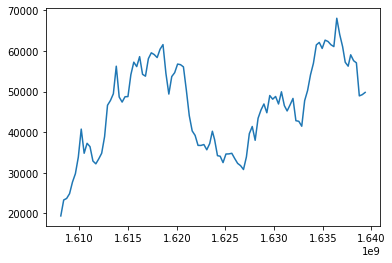

In [11]:
fig = plt.plot('timestamp', 'price', data=df_btc[::1000])

Ahora decidimos que el maximo de tiempo que vamos a predecir, es 7 días. Por lo que debemos eliminar lo tweets más recientes que no tienen valores en "data/btc_values.csv" 7 días después (La idea habría sido definirlos al principio, para no tener que conseguir el sentiment analysis de tweets que vamos a borrar o tener que usar la API de twitter para usuarios que no necesitamos. Pero no tenemos el tiempo para volver a correr el sentiment analysis. Aunque la posicion de este cleanup **no tiene efecto sobre el resultado final**)

In [57]:
day_7 = 7*24*60*60

p_len = len(df)
df = df[df["date"]+day_7 < np.max(df_btc['timestamp'])]
df = df.reset_index(drop=True)
print(f"{p_len-len(df)} tweets eliminados ({len(df)} restantes)")

0 tweets eliminados (4637 restantes)


Ahora, encontremos los extremos temporales de los tweets, para no tener que mostrar todo el historial que tenemos disponible

In [58]:
max = np.max(df['date']) + day_7
min = np.min(df['date'])

def get_price_near(timestamp):
    return df_btc.iloc[(df_btc['timestamp']-timestamp).abs().argsort()].iloc[0]["price"]


In [59]:
p_len = len(df_btc)
df_btc = df_btc[df_btc["timestamp"] > min]
df_btc = df_btc[df_btc["timestamp"] < max]
print(f"{p_len-len(df_btc)} fechas eliminadas ({len(df_btc)} restantes)")

2 fechas eliminadas (100375 restantes)


Ahora, encontremoas a un tweet al azar y mostremoslo en el grafico (tweet 8)

1638726338.0 49242.23519008295


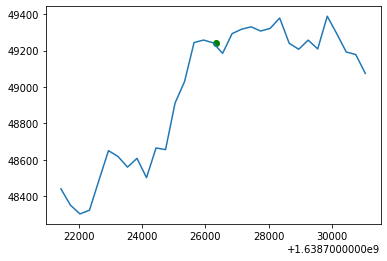

In [111]:
tweet_date = df.iloc[8]['date']

df_btc_short = df_btc[df_btc["timestamp"] > tweet_date-5000]
df_btc_short = df_btc_short[df_btc_short["timestamp"] < tweet_date+5000]

print(tweet_date, get_price_near(tweet_date))

fig = plt.plot('timestamp', 'price', data=df_btc_short)
plt.scatter(tweet_date, get_price_near(tweet_date), color='green')

Nos podemos dar cuenta de que nos estamos acercando a nuestro objetivo, ahora hay que ver "cuanto" cambia el precio del bitcoin después de cada tweet

Para esto, vamos a crear 6 nuevas columnas a los tweets: Los deltas de los precios después de 5 min, 30 min, 1h, 5h, 1d, 7d

In [63]:
min_5 = 5*60
min_30 = 30*60
hour_1 = 60*60
hour_5 = 5*hour_1
day_1= 24*hour_1
# day_7 is already defined

# def date_func(row):
#     now_price = get_price_near(row["date"])
#     if row['eri_hispanic'] == 1 :
#         return 'Hispanic'

time_5m = []
time_30m = []
time_1h = []
time_5h = []
time_1d = []
time_7d = []

tweet_amount = len(df.date)
for d_id, tweet_date in enumerate(df.date):
    print(f"{d_id}/{tweet_amount}\r", end="")
    now_price = get_price_near(tweet_date)
    time_5m.append(get_price_near(tweet_date+min_5)-now_price)
    time_30m.append(get_price_near(tweet_date+min_30)-now_price)
    time_1h.append(get_price_near(tweet_date+hour_1)-now_price)
    time_5h.append(get_price_near(tweet_date+hour_5)-now_price)
    time_1d.append(get_price_near(tweet_date+day_1)-now_price)
    time_7d.append(get_price_near(tweet_date+day_7)-now_price)

df["price_delta_5m"] = time_5m
df["price_delta_30m"] = time_30m
df["price_delta_1h"] = time_1h
df["price_delta_5h"] = time_5h
df["price_delta_1d"] = time_1d
df["price_delta_7d"] = time_7d
print("Done!"+" "*20)

Done!                    


In [64]:
df.head()

,Unnamed: 0,p_id,date,tweet,sentiment_begin,sentiment_end,sentiment_very_positive,sentiment_positive,sentiment_neutral,sentiment_negative,sentiment_very_negative,price_delta_5m,price_delta_30m,price_delta_1h,price_delta_5h,price_delta_1d,price_delta_7d
0,1384,airdropinspect,1.638738e+09,New airdrop: AAG Ventures x reBaked (AAG. Tota...,Negative,Negative,0,0,4,5,0,-85.581230,-385.060737,180.129040,-240.666796,-83.924315,1299.076315
1,1385,airdropinspect,1.638737e+09,New airdrop: Fight Of The Age. Total Reward: $...,Neutral,Negative,0,0,5,4,0,72.252379,-291.041687,193.670078,-183.502898,233.796049,1371.328694
2,1391,airdropinspect,1.638734e+09,New airdrop: GOGOcoin (GOGO. Total Reward: $50...,Neutral,Negative,0,0,6,3,0,122.985827,300.466493,204.621643,-99.186631,369.022376,1429.688490
3,1392,CoinDesk,1.638733e+09,"""I see bitcoin as the world reserve asset, whe...",Negative,Neutral,0,0,4,2,0,239.644804,408.888906,193.395442,181.597210,656.958093,1738.365983
4,1396,airdropinspect,1.638731e+09,"New airdrop: Onepad (BUSD. Total Reward: $5,00...",Neutral,Negative,0,0,7,2,0,-176.524716,-449.372870,-40.483964,197.700788,261.285347,1455.487485


Eliminar columnas sin nombre

In [128]:
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

Ahora podemos empezar con la regreción

In [130]:
df_analysis = df.copy(deep=True)

followers = []
following = []
listed_count = []
tweet_count = []
verified = []

p_len = len(df)
for u_id, user in enumerate(df.iloc):
    print(f"{u_id+1}/{p_len}\r", end="")
    usr = df_users[df_users["username"] == user["p_id"]].iloc[0]
    followers.append(usr["followers"])
    following.append(usr["following"])
    listed_count.append(usr["listed count"])
    tweet_count.append(usr["tweet count"])
    verified.append(usr["verified"])

df_analysis["followers"] = followers
df_analysis["following"] = following
df_analysis["listed count"] = listed_count
df_analysis["tweet count"] = tweet_count
df_analysis["verified"] = verified

df_analysis = df_analysis.drop(["p_id", "date", "tweet", "sentiment_begin", "sentiment_end"], axis="columns", )
print("Done!" + " "*20)

Done!                    


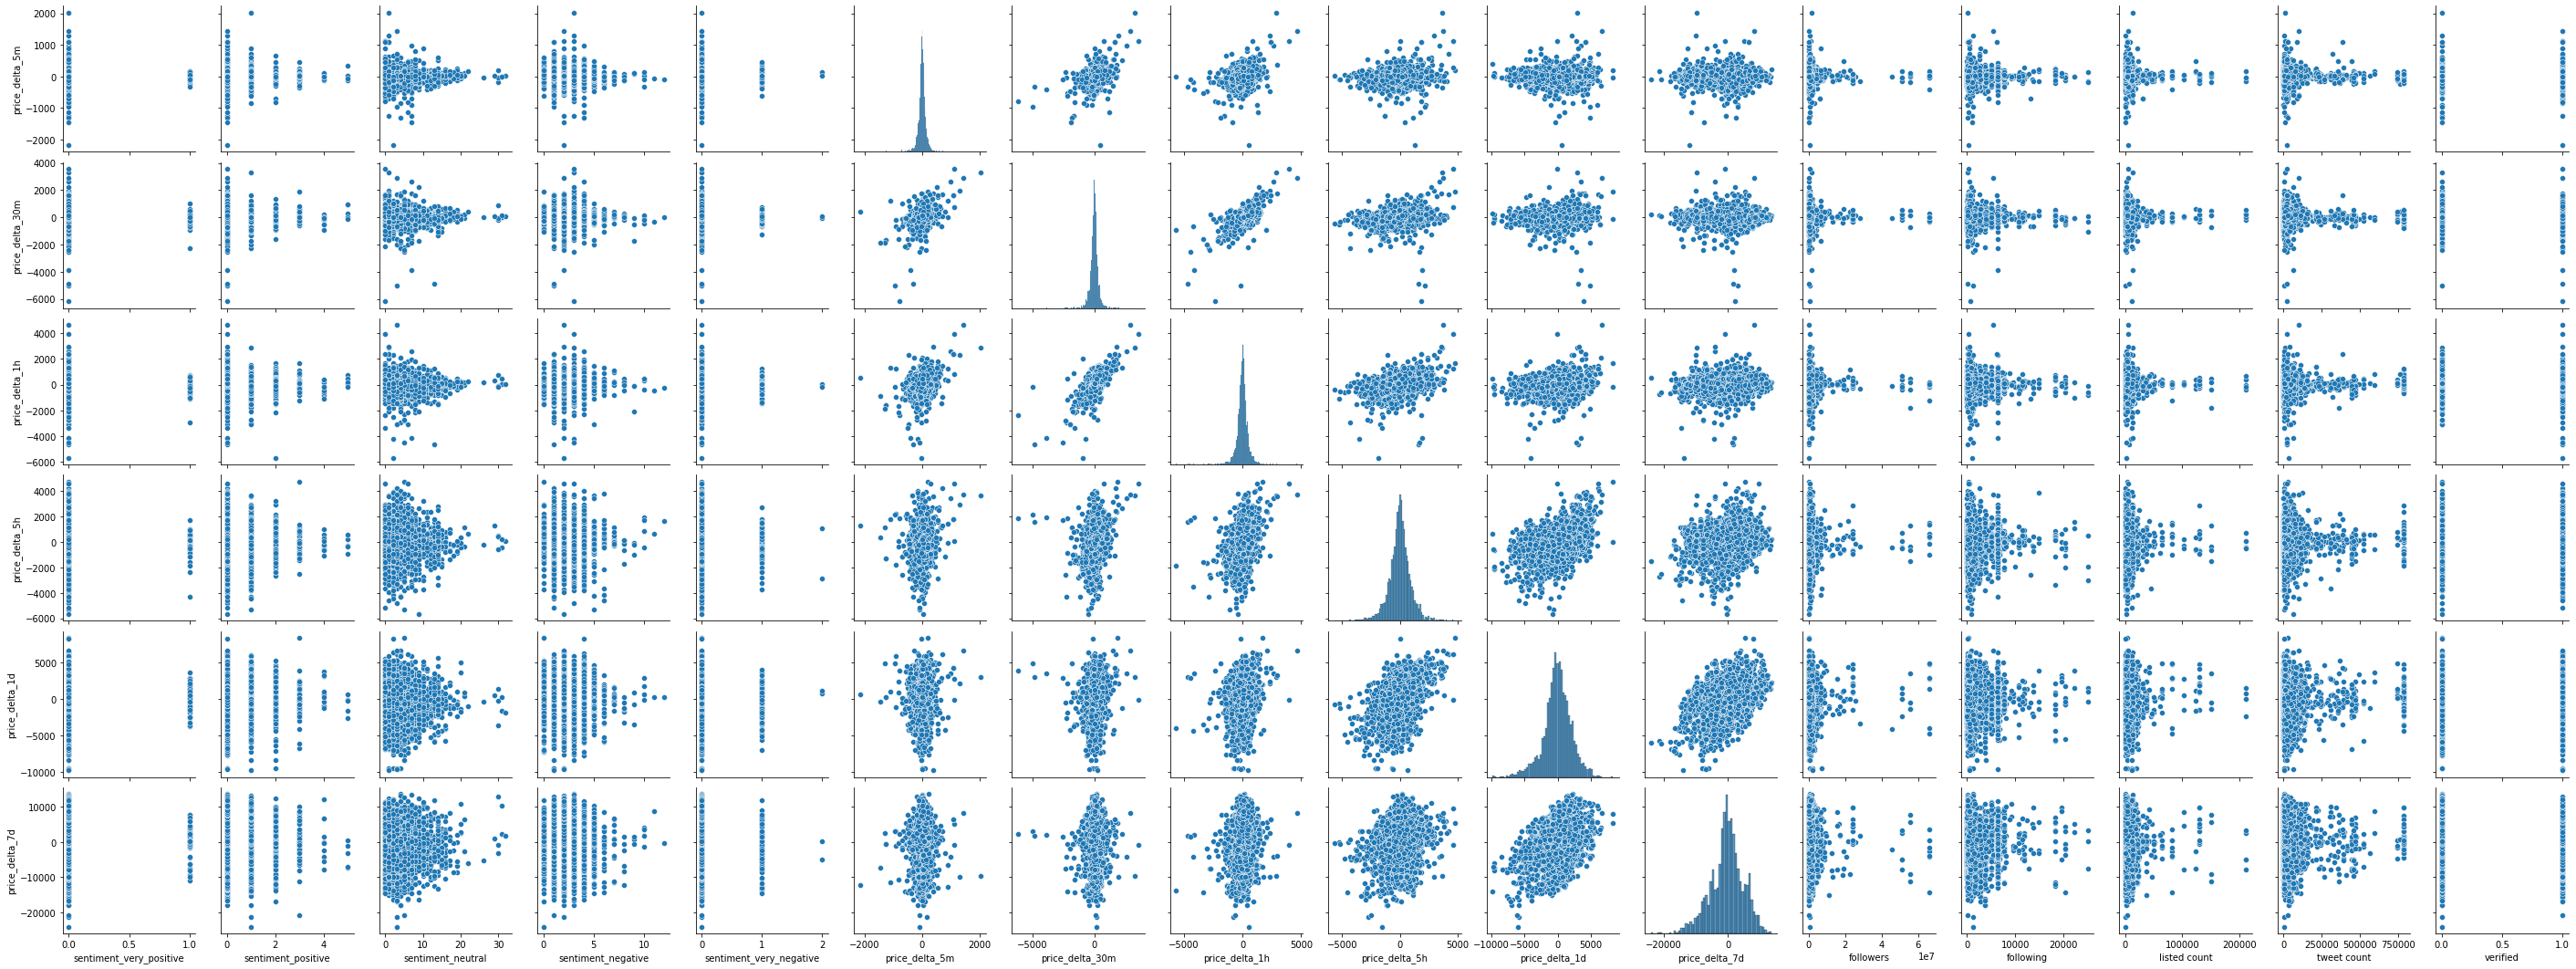

In [132]:
sns.pairplot(df_analysis,y_vars=['price_delta_5m', 'price_delta_30m', 'price_delta_1h', 'price_delta_5h', 'price_delta_1d', 'price_delta_7d'])

Como podemos ver con los graficos en x=sentiment_*, mientras más frases en el tweet, tiende a haber un menor cambio de precio, pero como podemos ver, también hay una menor cantidad de tweets mientras mayor cantidad de frases con algun sentimiento, por lo que no es una metrica que podamos utilizar directamente sin juntarla con alguna otra.

Utilizando las metricas de delta de precios, para predecir los futuros precios, solo se ve factible a corto plazo, ya que por ejemplo con el grafico de price_delta_5m vs el price_delta_7d podemos ver que la varianza de uno, no afecta **mucho** al otro.

La cantidad de followers, parece generar menos cambios en el precio mientras mayor sea el numero de seguidores, pero esto, puede ser porque estas personas tienden a ser más objetivos tratando de no interferir. Esto lo podríamos ver generando graficos con los followers y los sentimientos de los mensajes vs el delta de precios.

El following, no parece tener mucho efecto al largo plazo, lo que estaba dentro de lo esperado, aunque por otra parte, a corto plazo, se tiene un comportamiento similar al de los followers, pero esto debe pasar porque no hay suficientes mensajes.

El listed_count tiene comportamiento como el de following, lo que no era de esperarse, ya que uno pensaría que mientras más cantidad de grupos una persona pertenece, más influencial sería. Pero denuevo, no es una metrica que podamos juzgar directamente sin otras.

El tweet_count, muestra un comportamiento interesante, ya que como podemos ver, a medida que se incrementa la cantidad de tweets/persona, menor cantidad de tweets relacionados a esta investigación encontramos, pero sobre 750.000 tweets/persona encontramos un grupo que aparte de ser influyentes incluso a largo plazo (pero se necesita más información para ser concluyentes de esto), tenemos que repentinamente, tenemos una mayor cantidad de tweets recolectados. Estos, por ejemplo, pueden ser bots que anuncian noticias relacionadas al bitcoin.

Para los usuarios verificados, vemos que en 30m y 1h, hay tweets que **parecen** afectar al delta del precio en esos instantes más que los no verificados.

<AxesSubplot:xlabel='sentiment_negative', ylabel='price_delta_1d'>

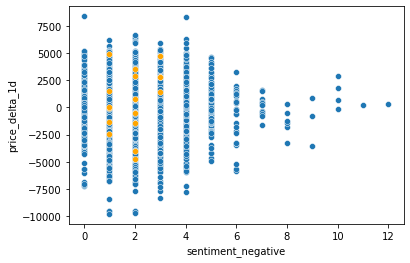

In [191]:
df_analysis_sub = df_analysis.copy(deep=True)

sns.scatterplot('sentiment_negative', 'price_delta_1d', data=df_analysis_sub)
sns.scatterplot('sentiment_negative', 'price_delta_1d', data=df_analysis_sub[df_analysis_sub["followers"] > 5e7], color="orange")

In [199]:
df[df_analysis_sub["followers"] > 5e7].iloc[10]["tweet"]

"Bitcoin and Ethereum aren't the only digital currencies that are hitting record highs this week. Dogecoin, the crypocurrency that features the face of a Shiba Inu dog as its logo, has surpassed 10 cents for the first time. https://t.co/zog2w3dRgy"

2

1. Regression para desde followers, ... llegar a el delta de precios
2. K-Means clustering para desde followers, ...usuario... saber si puede enviar un tweet que pueda afectar en más de {x} USD el precio.